In [4]:
%load_ext autoreload
%autoreload 2

In [28]:
%set_env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [5]:
import sys
import collections
import cv2
import os
import math
import random
import pickle
import copy
import numpy as np
sys.path.append("C:\\Users\\user\\Documents\\Workspace\\MeronymNet-PyTorch\\src")

In [6]:
import torch
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import DataLoader
import torch.utils.data as data_utils
from torch.utils.tensorboard import SummaryWriter

In [7]:
from losses import BoxVAE_losses as loss
from components.DenseAutoencoder import DenseAutoencoder
from components.DenseAutoencoder import Decoder
from components.TwoStageAutoEncoder import TwoStageAutoEncoder

In [32]:
import matplotlib.pyplot as plt

In [81]:
colors = [(1, 0, 0),
          (0.737, 0.561, 0.561),
          (0.255, 0.412, 0.882),
          (0.545, 0.271, 0.0745),
          (0.98, 0.502, 0.447),
          (0.98, 0.643, 0.376),
          (0.18, 0.545, 0.341),
          (0.502, 0, 0.502),
          (0.627, 0.322, 0.176),
          (0.753, 0.753, 0.753),
          (0.529, 0.808, 0.922),
          (0.416, 0.353, 0.804),
          (0.439, 0.502, 0.565),
          (0.784, 0.302, 0.565),
          (0.867, 0.627, 0.867),
          (0, 1, 0.498),
          (0.275, 0.51, 0.706),
          (0.824, 0.706, 0.549),
          (0, 0.502, 0.502),
          (0.847, 0.749, 0.847),
          (1, 0.388, 0.278),
          (0.251, 0.878, 0.816),
          (0.933, 0.51, 0.933),
          (0.961, 0.871, 0.702)]
colors = (np.asarray(colors)*255)
canvas_size = 660

def plot_bbx(bbx):
    bbx = bbx*canvas_size
    canvas = np.ones((canvas_size,canvas_size,3), np.uint8) * 255
    for i, coord in enumerate(bbx):
        x_minp, y_minp,x_maxp , y_maxp = coord[:4]
        if [x_minp, y_minp, x_maxp, y_maxp]!=[0,0,0,0]:
            cv2.rectangle(canvas, (int(x_minp), int(y_minp)), (int(x_maxp) , int(y_maxp) ), colors[i], 6)
    return canvas

def plot_obj_bbx(bbx):
    bbx = bbx*canvas_size
    canvas = np.ones((canvas_size,canvas_size,3), np.uint8) * 255
    x_minp, y_minp,x_maxp , y_maxp = bbx
    cv2.rectangle(canvas, (int(x_minp), int(y_minp)), (int(x_maxp) , int(y_maxp) ), colors[0], 6)
    return canvas

# def plot_bbx(bbx):
#     bbx = bbx*canvas_size
#     canvas = np.ones((canvas_size,canvas_size,3), np.uint8) * 255
#     for i, coord in enumerate(bbx):
#         x, y, w ,h = coord
#         if [x, y, w ,h]!=[0,0,0,0]:
#             cv2.rectangle(canvas, (int(x), int(y)), (int(x + w) , int(y + h) ), colors[i], 6)
#     return canvas


In [34]:
def inference_obj(decoder, node_data):

    decoder.cuda()
    z_latent = torch.normal(torch.zeros([batch_size,latent_dims])).cuda()
    nodes = torch.reshape(nodes,(batch_size,decoder.num_nodes))
    obj_class = torch.reshape(obj_class,(batch_size, decoder.class_size))
    conditioned_z = torch.cat([nodes, z_latent],dim=-1)
    conditioned_z = torch.cat([obj_class, conditioned_z],dim=-1)
    
    op = decoder(conditioned_z)
        
    return op[0], op[1], z_latent


def inference(decoder, nodes, obj_class, latent_dims, batch_size):

    decoder.cuda()
    z_latent = torch.normal(torch.zeros([batch_size,latent_dims])).cuda()
    nodes = torch.reshape(nodes,(batch_size,decoder.num_nodes))
    obj_class = torch.reshape(obj_class,(batch_size, decoder.class_size))
    conditioned_z = torch.cat([nodes, z_latent],dim=-1)
    conditioned_z = torch.cat([obj_class, conditioned_z],dim=-1)
    
    op = decoder(conditioned_z)
        
    return op[0], op[1], z_latent

In [35]:
obj_data_postfix = '_obj_boundary'
part_data_post_fix = '_scaled'
file_postfix = '_combined'
outfile = 'D:/meronym_data/X_train'+part_data_post_fix+'.np'
with open(outfile, 'rb') as pickle_file:
    X_train = pickle.load(pickle_file)

outfile = 'D:/meronym_data/X_train'+obj_data_postfix+'.np'
with open(outfile, 'rb') as pickle_file:
    X_obj_train = pickle.load(pickle_file)

outfile = 'D:/meronym_data/class_v'+file_postfix+'.np'
with open(outfile, 'rb') as pickle_file:
    class_v = pickle.load(pickle_file)

outfile = 'D:/meronym_data/adj_train'+file_postfix+'.np'
with open(outfile, 'rb') as pickle_file:
    adj_train = pickle.load(pickle_file)

outfile = 'D:/meronym_data/X_train_val'+part_data_post_fix+'.np'
with open(outfile, 'rb') as pickle_file:
    X_train_val = pickle.load(pickle_file)

outfile = 'D:/meronym_data/X_train_val'+obj_data_postfix+'.np'
with open(outfile, 'rb') as pickle_file:
    X_obj_train_val = pickle.load(pickle_file)

outfile = 'D:/meronym_data/class_v_val'+file_postfix+'.np'
with open(outfile, 'rb') as pickle_file:
    class_v_val = pickle.load(pickle_file)
    
outfile = 'D:/meronym_data/adj_train_val'+file_postfix+'.np'
with open(outfile, 'rb') as pickle_file:
    adj_train_val = pickle.load(pickle_file)
    
outfile = 'D:/meronym_data/X_test'+part_data_post_fix+'.np'
with open(outfile, 'rb') as pickle_file:
    X_test = pickle.load(pickle_file)

outfile = 'D:/meronym_data/X_test'+obj_data_postfix+'.np'
with open(outfile, 'rb') as pickle_file:
    X_obj_test = pickle.load(pickle_file)

outfile = 'D:/meronym_data/adj_test'+file_postfix+'.np'
with open(outfile, 'rb') as pickle_file:
    adj_test = pickle.load(pickle_file)
    
outfile = 'D:/meronym_data/class_v'+file_postfix+'.np'
with open(outfile, 'rb') as pickle_file:
    class_v_test = pickle.load(pickle_file)

In [36]:
X_train[X_train<=0] = 0
X_train_val[X_train_val<=0] = 0
X_test[X_test<=0] = 0

X_train[X_train>=1] = 1
X_train_val[X_train_val>=1] = 1
X_test[X_test>=1] = 1

X_obj_train[X_obj_train<=0] = 0
X_obj_train_val[X_obj_train_val<=0] = 0
X_obj_test[X_obj_test<=0] = 0

X_obj_train[X_obj_train>=1] = 1
X_obj_train_val[X_obj_train_val>=1] = 1
X_obj_test[X_obj_test>=1] = 1

In [37]:
print(X_train.shape)
print(X_train_val.shape)
print(X_test.shape)

(50910, 16, 5)
(6720, 16, 5)
(10380, 16, 5)


In [38]:
print(adj_train.shape)
print(adj_train_val.shape)
print(adj_test.shape)

(50910, 16, 16)
(6720, 16, 16)
(354435, 16, 16)


In [39]:
random.seed(100)
train_idx = np.random.randint(1,len(X_train),len(X_train))
val_idx = np.random.randint(1,len(X_train_val),len(X_train_val))
test_idx = np.random.randint(1,len(X_test),len(X_test))

In [40]:
batch_size = 128
seed = 345

torch.manual_seed(seed)

validation = True
if validation:
    train_list =[]
    for idx, batch in enumerate(zip(copy.deepcopy(X_train[train_idx]),
                                    copy.deepcopy(np.concatenate([class_v[train_idx], X_obj_train[train_idx]], axis=-1)),
                                    copy.deepcopy(adj_train[train_idx]))):
        edge_index, _ = dense_to_sparse(torch.from_numpy(batch[2]).cuda().float())
        train_list.append(Data(x = torch.from_numpy(batch[0]).cuda().float(),
                               y = torch.from_numpy(batch[1]).cuda().float(),
                               edge_index = edge_index
                                    )
                         )

    batch_train_loader = DataLoader(train_list, batch_size=batch_size)

    val_list = []
    for idx, batch in enumerate(zip(copy.deepcopy(X_train_val[val_idx]),
                                    copy.deepcopy(np.concatenate([class_v_val[val_idx], X_obj_train_val[val_idx]], axis=-1)),
                                    copy.deepcopy(adj_train_val[val_idx]))):
        edge_index, _ = dense_to_sparse(torch.from_numpy(batch[2]).cuda().float())
        val_list.append(Data(x = torch.from_numpy(batch[0]).cuda().float(),
                             y = torch.from_numpy(batch[1]).cuda().float(),
                             edge_index = edge_index
                                    )
                         )
    batch_val_loader = DataLoader(val_list, batch_size=batch_size)
else:
    train_list =[]
    for idx, batch in enumerate(zip(copy.deepcopy(X_train[train_idx]),
                                    copy.deepcopy(np.concatenate([class_v[train_idx], X_obj_train[train_idx]], axis=-1)),
                                    copy.deepcopy(adj_train[train_idx]))):
        edge_index, _ = dense_to_sparse(torch.from_numpy(batch[2]).cuda())
        train_list.append(Data(x = torch.from_numpy(batch[0]).cuda(),
                               y = torch.from_numpy(batch[1]).cuda(),
                               edge_index = edge_index
                                    )
                         )
    
    for idx, batch in enumerate(zip(copy.deepcopy(X_train_val[val_idx]),
                                    copy.deepcopy(np.concatenate([class_v_val[val_idx], X_obj_train_val[val_idx]], axis=-1)),
                                    copy.deepcopy(adj_train_val[val_idx]))):
        edge_index, _ = dense_to_sparse(torch.from_numpy(batch[2]).cuda())
        train_list.append(Data(x = torch.from_numpy(batch[0]).cuda(),
                             y = torch.from_numpy(batch[1]).cuda(),
                             edge_index = edge_index
                                    )
                         )
    batch_train_loader = DataLoader(train_list, batch_size=batch_size)
    
    val_list = []
    for idx, batch in enumerate(zip(copy.deepcopy(X_test[test_idx]),
                                    copy.deepcopy(np.concatenate([class_v_test[test_idx], X_obj_test[test_idx]], axis=-1)), 
                                    copy.deepcopy(adj_test[test_idx]))):
        edge_index, _ = dense_to_sparse(torch.from_numpy(batch[2]).cuda())
        val_list.append(Data(x = torch.from_numpy(batch[0]).cuda(),
                             y = torch.from_numpy(batch[1]).cuda(),
                             edge_index = edge_index
                                    )
                         )
    batch_val_loader = DataLoader(val_list, batch_size=batch_size)
    

C:\Users\user\miniconda3\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [41]:
del train_list
del val_list
del X_train
del X_obj_train
del class_v
del adj_train
del X_train_val
del X_obj_train_val
del class_v_val
del adj_train_val

In [42]:
idx = 0
for data in batch_train_loader:
    idx+=1
    print(data.x.shape, data.y.shape)
    if idx==3:
        break

torch.Size([2048, 5]) torch.Size([128, 11])
torch.Size([2048, 5]) torch.Size([128, 11])
torch.Size([2048, 5]) torch.Size([128, 11])


In [44]:
latent_dims = 64
num_nodes = 16
bbx_size = 4
num_classes = 7
label_shape = 1
nb_epochs = 1000
klw = loss.frange_cycle_linear(nb_epochs)
learning_rate = 0.000095
hidden1 = 32
hidden2 = 16
hidden3 = 128
dense_hidden1=16
dense_hidden2=32
adaptive_margin = True
fine_tune_box = False
output_log = False
area_encoding = False
run_prefix = "two_stage_variational_obj_parts_conditioning_weighted_IOU"
variational=False

In [45]:
import gc
gc.collect()

114

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [47]:
def canvas_scaled_coodrinates(true,pred,true_box,pred_box, label_true):
    
    label_true = label_true.reshape([true.shape[0], true.shape[1], 1])
    
    batch_len  = true.shape[0]
    for i in range(batch_len):
        
        min_x, min_y, max_x, max_y = true_box[i][0],true_box[i][1], true_box[i][2],true_box[i][3] 
        
        labels = torch.where(label_true[i, :, 0]==1)[0]
        
        true_scaled_canvas = torch.tensor(true)
        
        true_scaled_canvas[i][labels,0] = min_x + (max_x - min_x) * true_scaled_canvas[i][labels,0]
        true_scaled_canvas[i][labels,2] = min_x + (max_x - min_x) * true_scaled_canvas[i][labels,2]
        
        true_scaled_canvas[i][labels,1] = min_y + (max_y - min_y) * true_scaled_canvas[i][labels,1]
        true_scaled_canvas[i][labels,3] = min_y + (max_y - min_y) * true_scaled_canvas[i][labels,3]
        
        min_x, min_y, max_x, max_y = pred_box[i][0],pred_box[i][1], pred_box[i][2],pred_box[i][3] 
        pred_scaled_canvas = torch.tensor(pred)
       
        pred_scaled_canvas[i][labels,0] = min_x + (max_x - min_x) * pred_scaled_canvas[i][labels,0]
        pred_scaled_canvas[i][labels,2] = min_x + (max_x - min_x) * pred_scaled_canvas[i][labels,2]
        
        pred_scaled_canvas[i][labels,1] = min_y + (max_y - min_y) * pred_scaled_canvas[i][labels,1]
        pred_scaled_canvas[i][labels,3] = min_y + (max_y - min_y) * pred_scaled_canvas[i][labels,3]



    return true_scaled_canvas,pred_scaled_canvas

In [48]:
def iou(true, pred, true_box , pred_box, label_true, flag_scale = False , flag_train = False):
    zero = torch.tensor([0.0]).cuda()
    true = torch.reshape(true, pred.shape)
    if flag_scale ==  True:
        true,pred = canvas_scaled_coodrinates(true,pred,true_box,pred_box, label_true)
    else:
        pass
    x1g, y1g, x2g, y2g = torch.tensor_split(true, 4, dim=-1)
    x1, y1, x2, y2 = torch.tensor_split(torch.squeeze(pred), 4, dim=-1)
    
    xA = torch.maximum(x1g, x1)
    yA = torch.maximum(y1g, y1)
    xB = torch.minimum(x2g, x2)
    yB = torch.minimum(y2g, y2)

    w, h = x2g-x1g, y2g-y1g
    
    
    interArea = torch.multiply(torch.maximum(zero,(xB - xA)), 
                                   torch.maximum(zero, (yB - yA)))
    boxAArea = torch.multiply(torch.maximum(zero, (x2g - x1g)),
                              torch.maximum(zero, (y2g - y1g)))
    boxBArea = torch.multiply(torch.maximum(zero, (x2 - x1)),
                                  torch.maximum(zero,(y2 - y1)))
    unionArea = boxAArea + boxBArea - interArea
    
    iouk = interArea / unionArea
    iouk = torch.nan_to_num(iouk)
    if flag_train == True:
        label_true = label_true.reshape([iouk.shape[0], iouk.shape[1], 1])
        idxs  = torch.nonzero(label_true)
        num = idxs.shape[0]
        idxs = idxs.split(1, dim=1)
        temp2 = torch.sum(iouk[idxs])/num
        return temp2
    else:
        return iouk

In [91]:
# Computes the IOU and MSE values for each of the models. 

# For each model, evaluates the IOU and MSE values for all the batches and stores them in the iou_loss and the mse_loss dictionary

# Defining all the variables. 
# Number of Dictionaries defined = Number of Models running
model_path = ('D:/meronym_data/model/'+run_prefix+'/Obj-Box-'
                        +str(learning_rate)
                        +'-batch-'+str(batch_size)
                        +'-h1-'+str(hidden1)
                        +'-h2-'+str(hidden2)
                        +'-h3-'+str(hidden3)+'-test')

vae = TwoStageAutoEncoder(latent_dims,
                          num_nodes,
                          bbx_size,
                          num_classes,
                          label_shape,
                          hidden1,
                          hidden2,
                          hidden3,
                          dense_hidden1,
                          dense_hidden2,
                          adaptive_margin,
                          output_log,
                          area_encoding
                        )
vae.load_state_dict(torch.load(model_path+ '/model_weights.pth'))

<All keys matched successfully>

pred


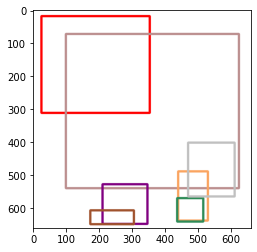

gt


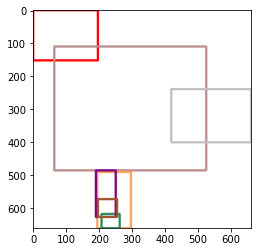

bird
bird done in Dict-1
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
cat
cat done in Dict-1
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
dog
dog done in Dict-1
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
sheep
sheep done in Dict-1
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
horse
horse done in Dict-1
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
person
person done in Dict-1
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
cow
cow done in Dict-1
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
pred


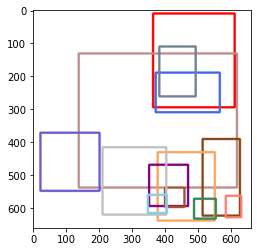

gt


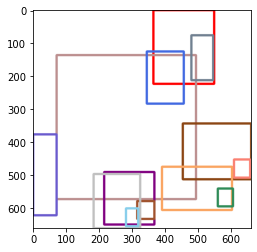

pred


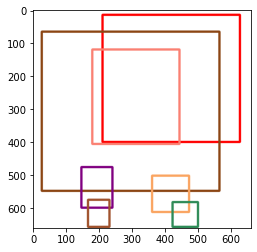

gt


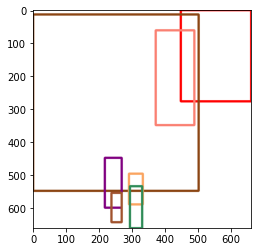

pred


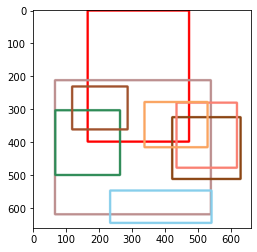

gt


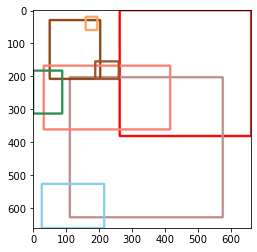

pred


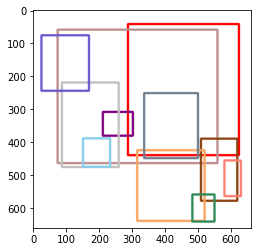

gt


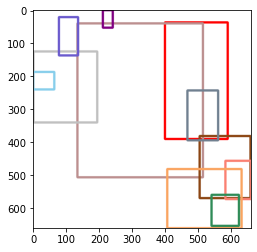

pred


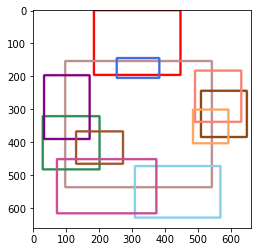

gt


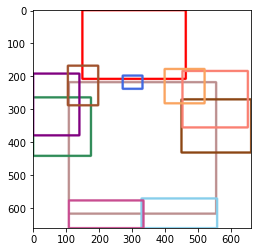

pred


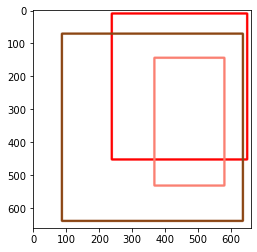

gt


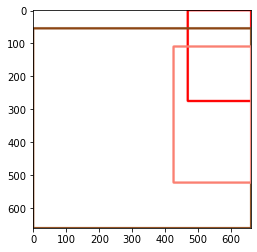

pred


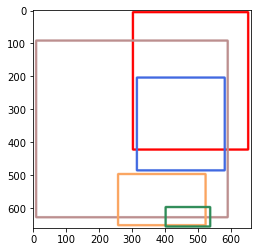

gt


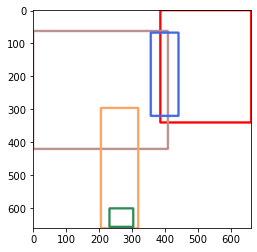

pred


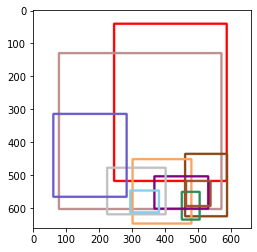

gt


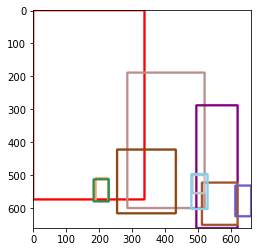

pred


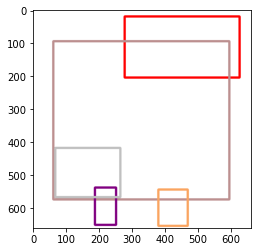

gt


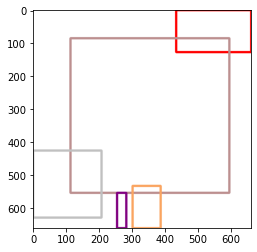

pred


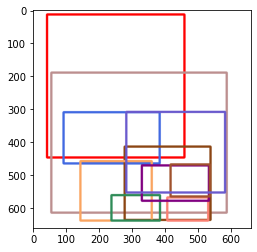

gt


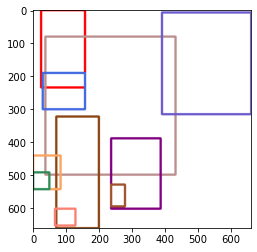

pred


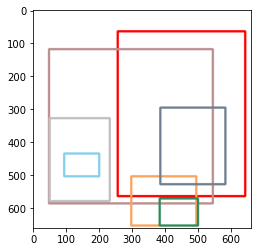

gt


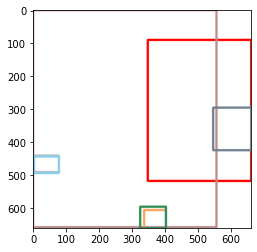

pred


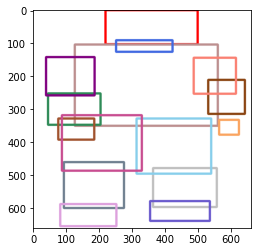

gt


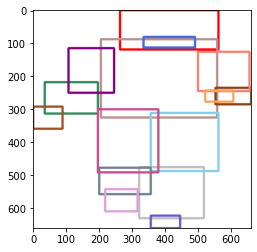

pred


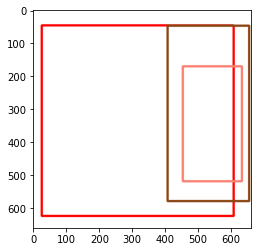

gt


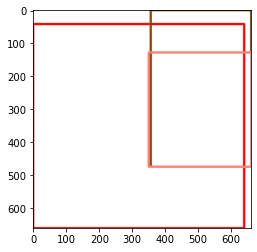

pred


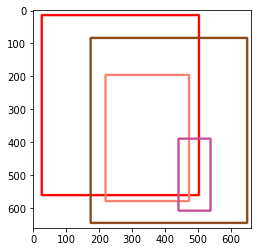

gt


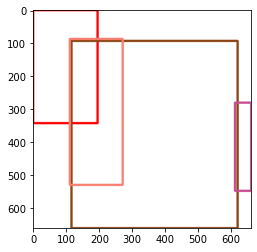

pred


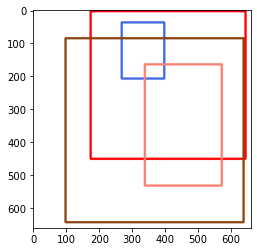

gt


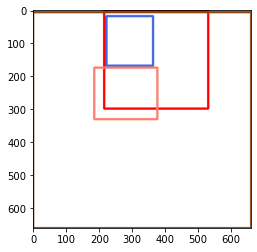

pred


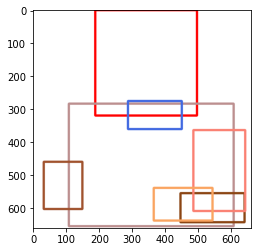

gt


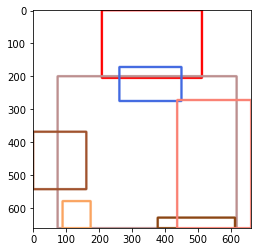

pred


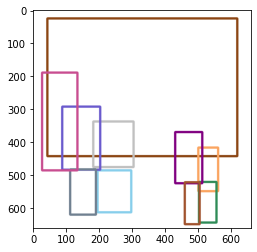

gt


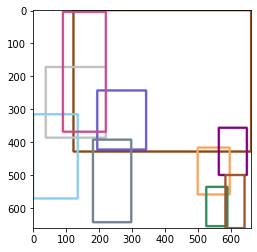

pred


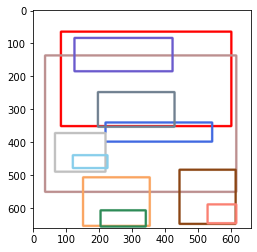

gt


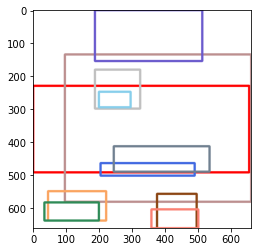

pred


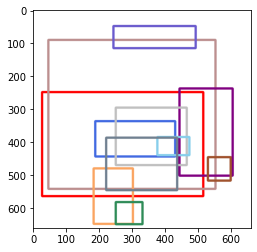

gt


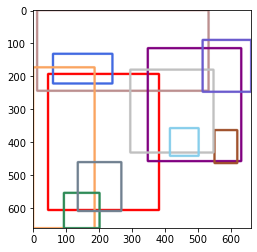

pred


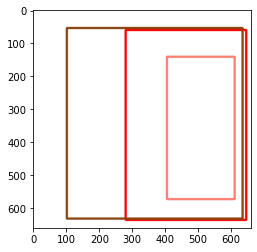

gt


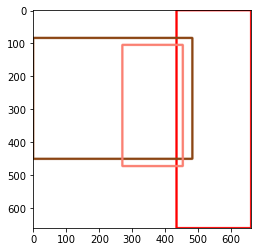

pred


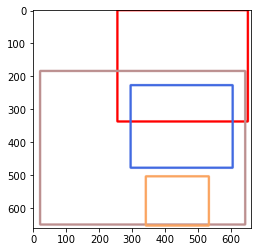

gt


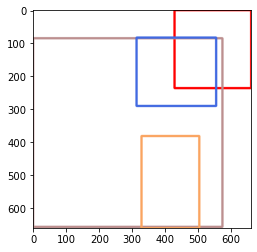

pred


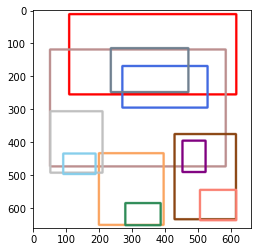

gt


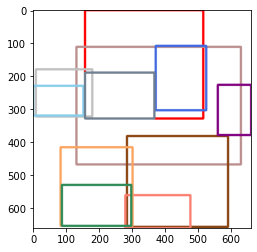

pred


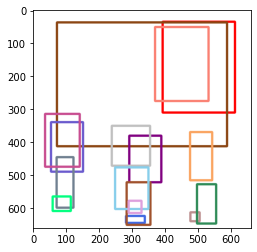

gt


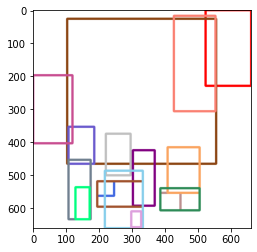

pred


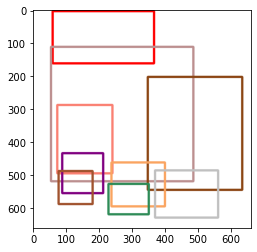

gt


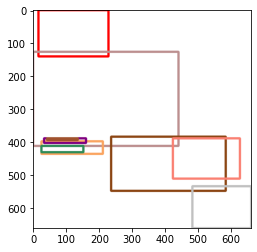

pred


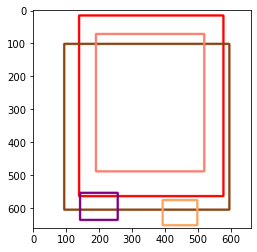

gt


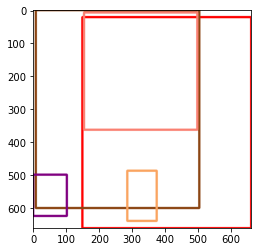

pred


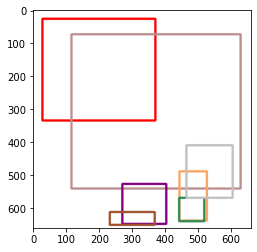

gt


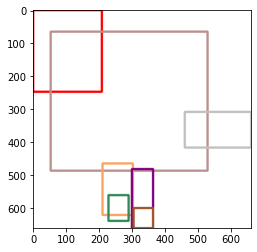

pred


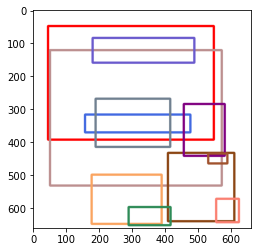

gt


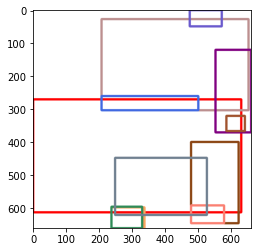

pred


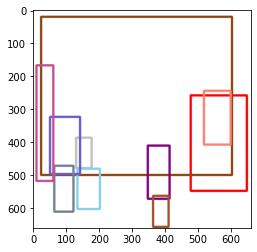

gt


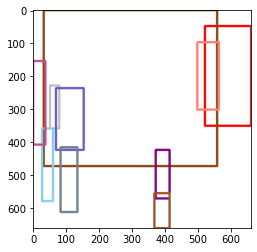

pred


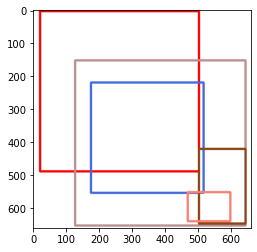

gt


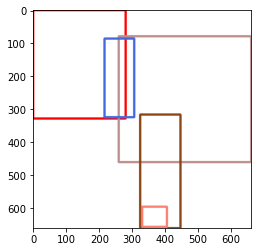

pred


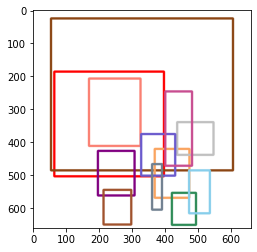

gt


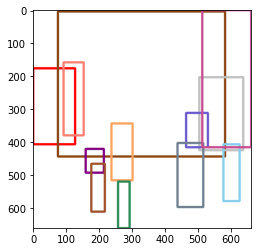

pred


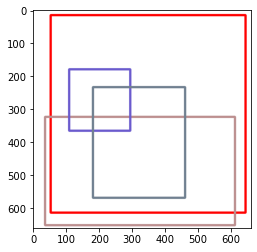

gt


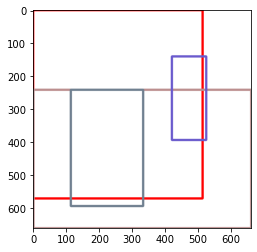

pred


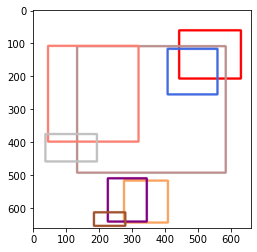

gt


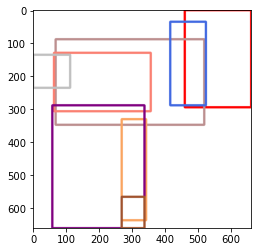

pred


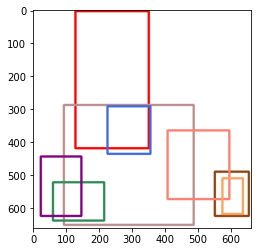

gt


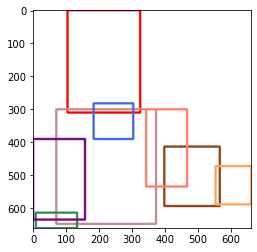

pred


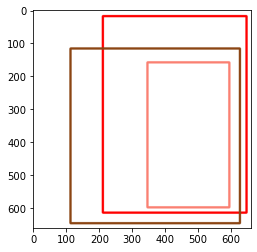

gt


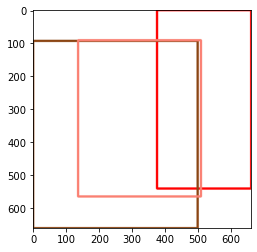

pred


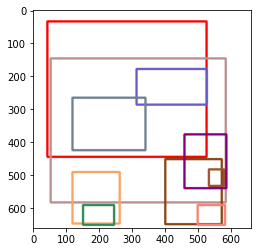

gt


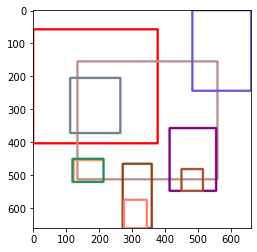

pred


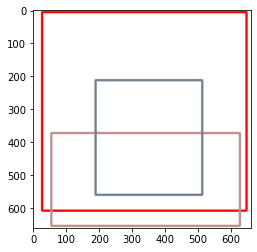

gt


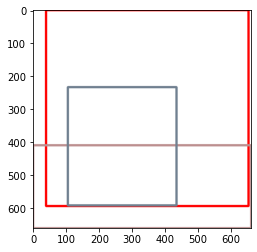

pred


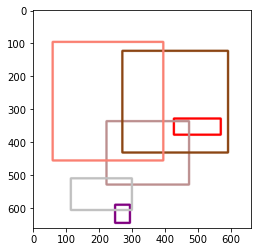

gt


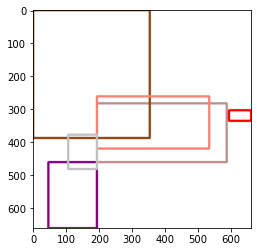

pred


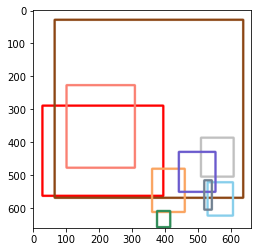

gt


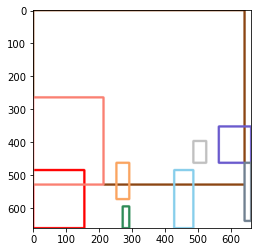

pred


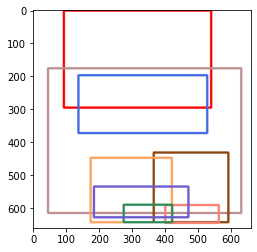

gt


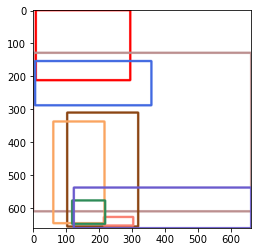

pred


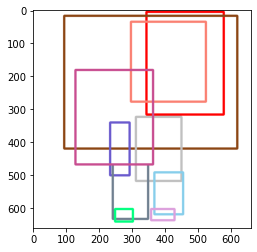

gt


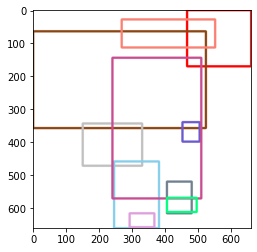

pred


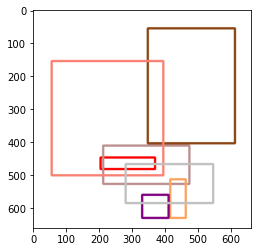

gt


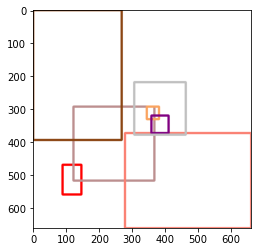

pred


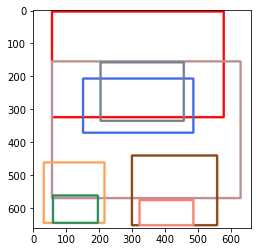

gt


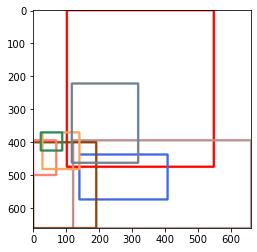

pred


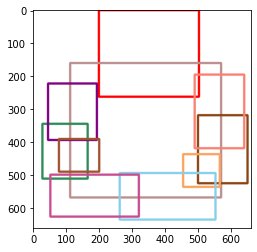

gt


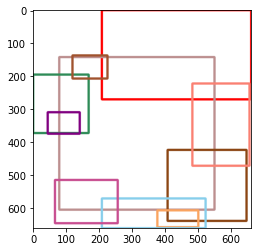

pred


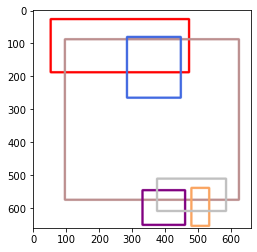

gt


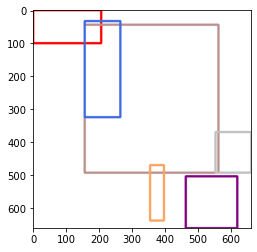

pred


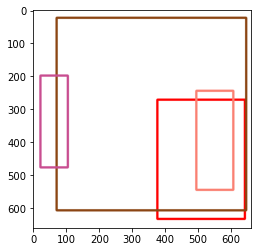

gt


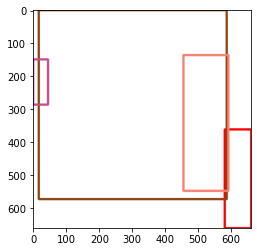

pred


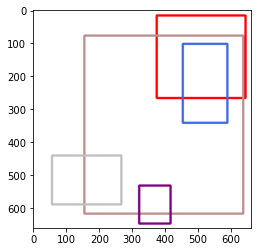

gt


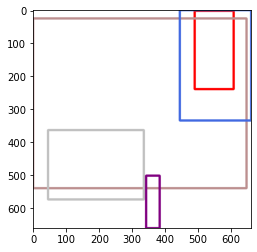

pred


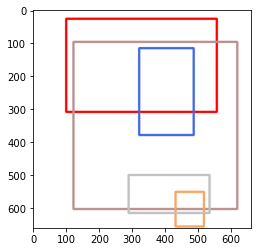

gt


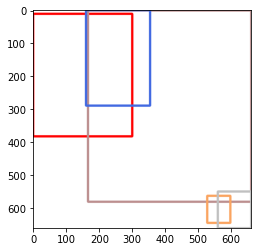

pred


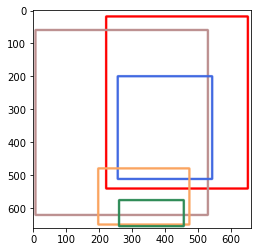

gt


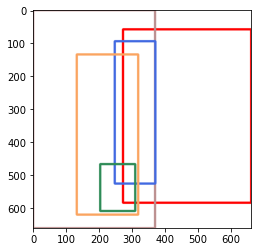

pred


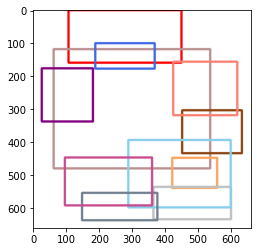

gt


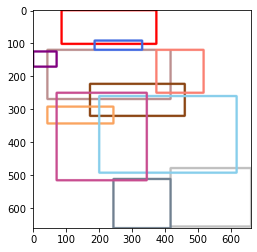

pred


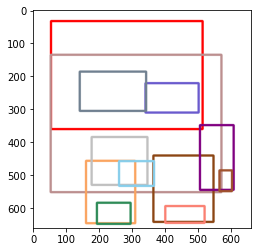

gt


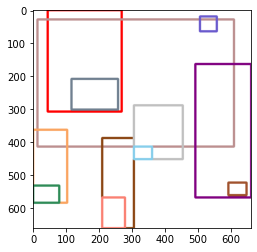

pred


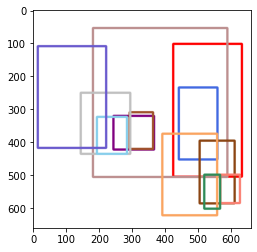

gt


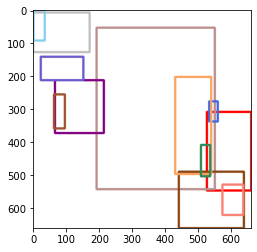

pred


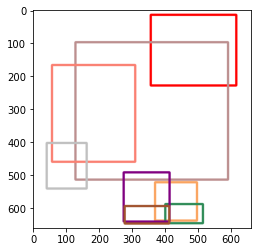

gt


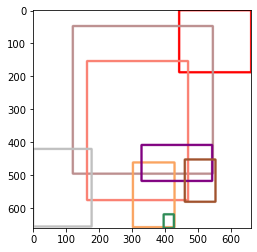

pred


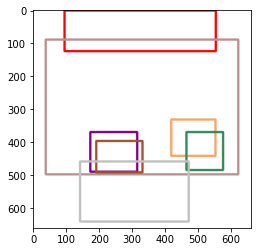

gt


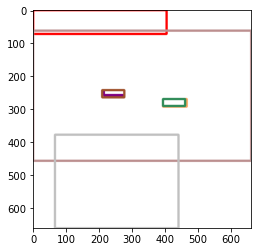

pred


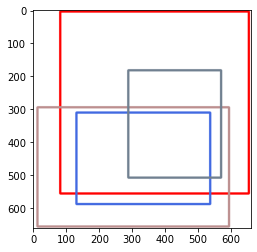

gt


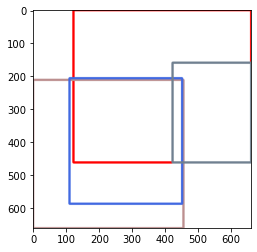

pred


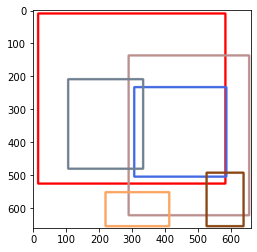

gt


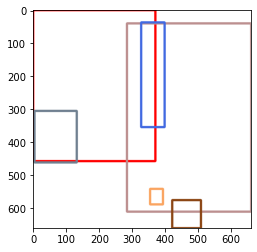

pred


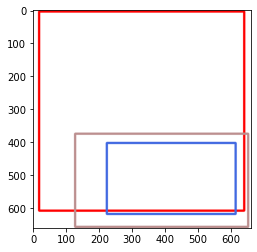

gt


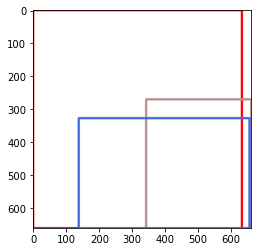

pred


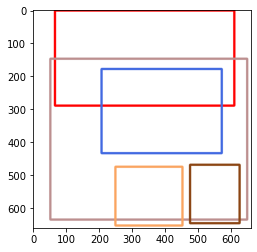

gt


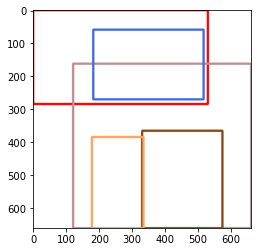

pred


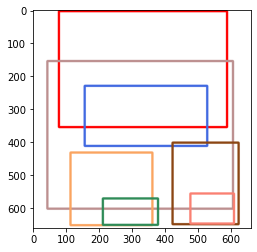

gt


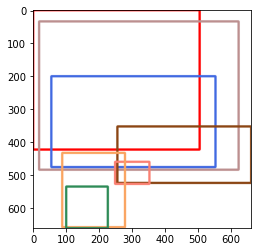

pred


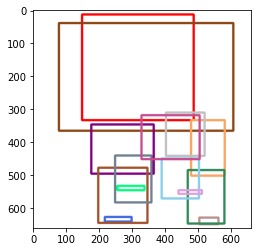

gt


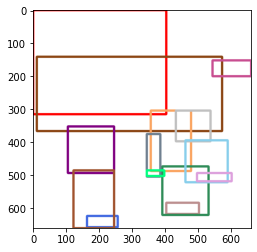

pred


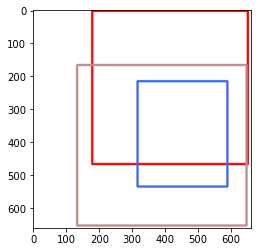

gt


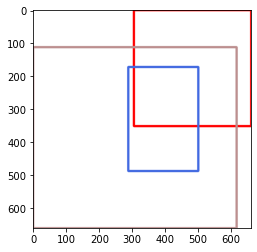

pred


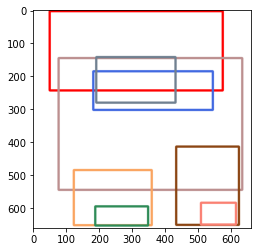

gt


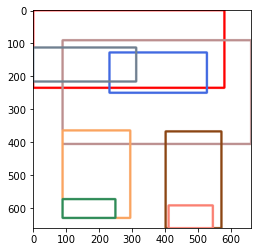

pred


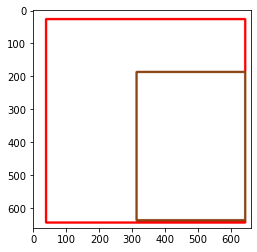

gt


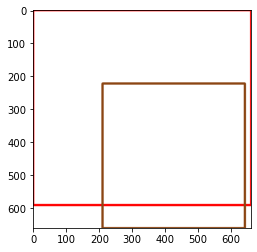

pred


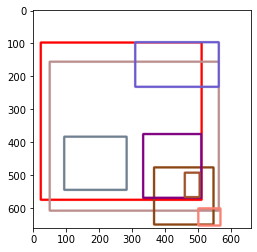

gt


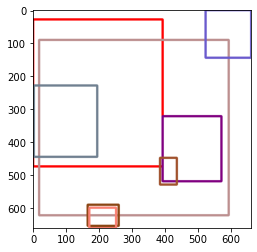

pred


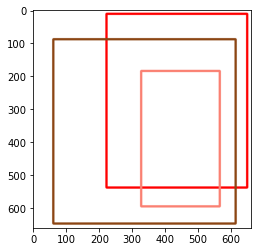

gt


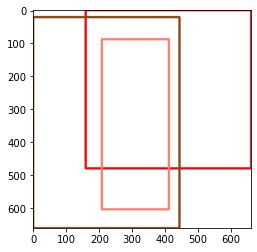

pred


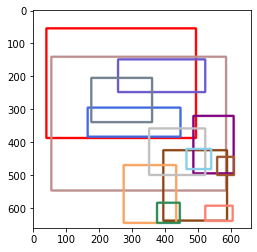

gt


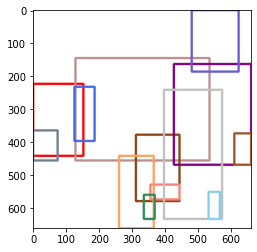

pred


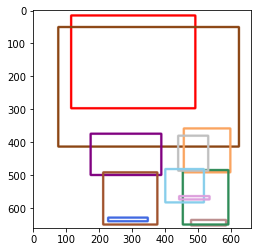

gt


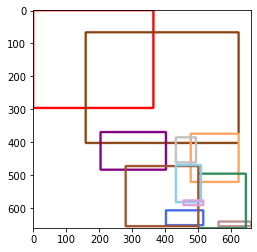

pred


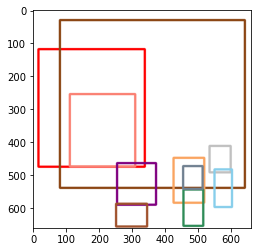

gt


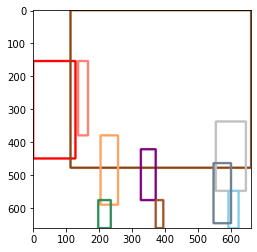

pred


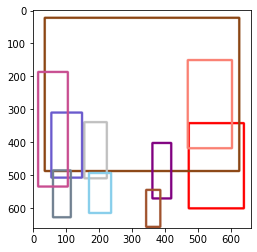

gt


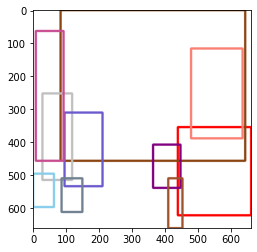

pred


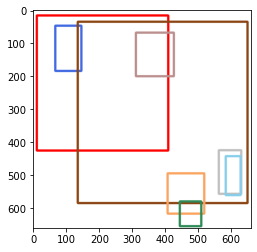

gt


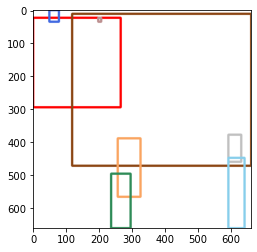

pred


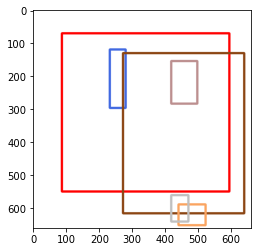

gt


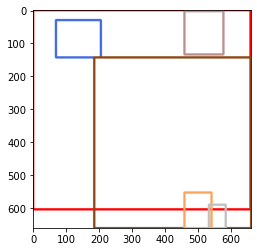

pred


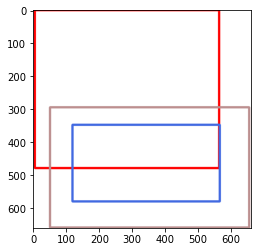

gt


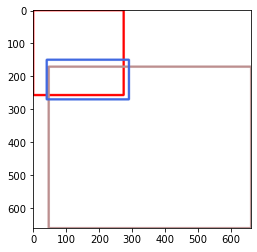

pred


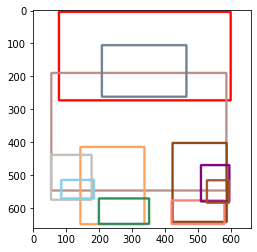

gt


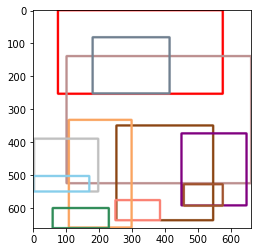

pred


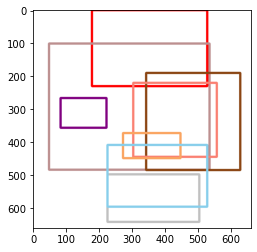

gt


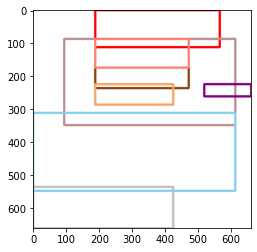

pred


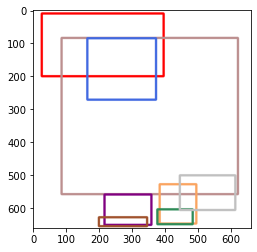

gt


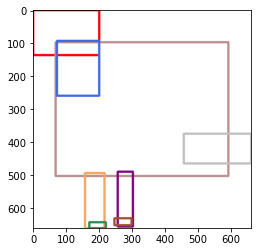

pred


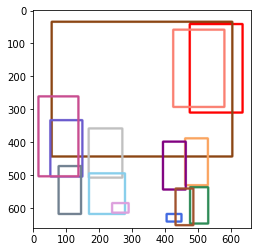

gt


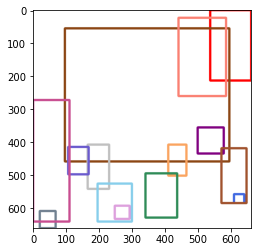

pred


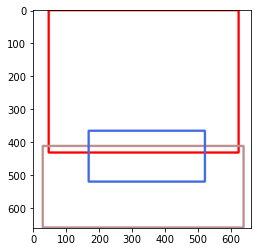

gt


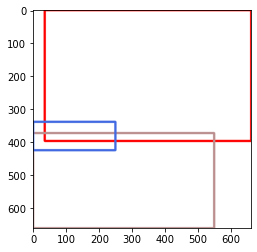

pred


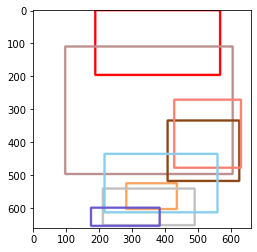

gt


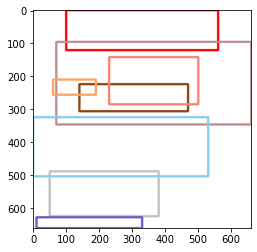

pred


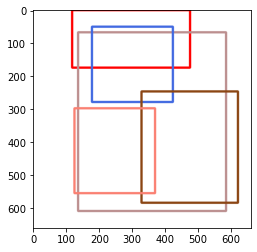

gt


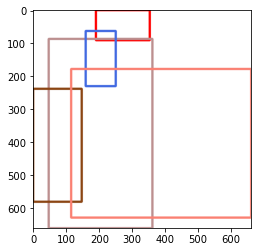

pred


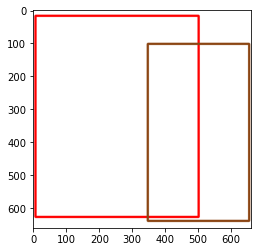

gt


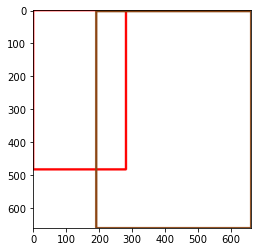

pred


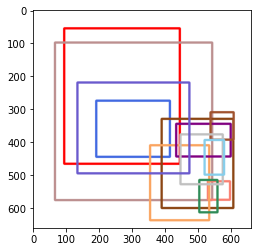

gt


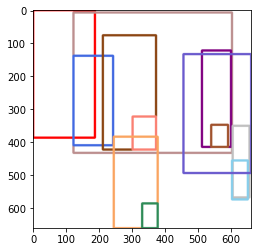

pred


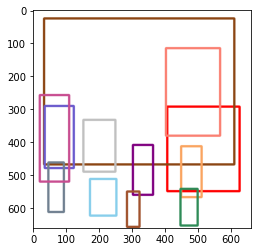

gt


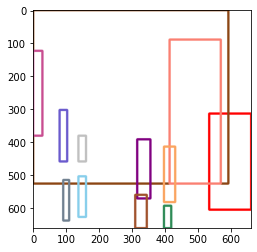

pred


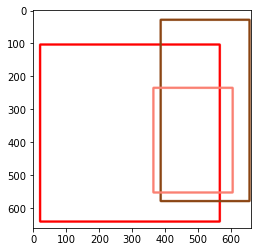

gt


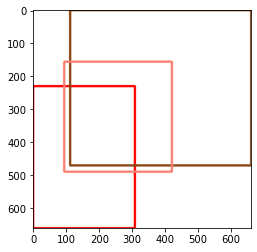

pred


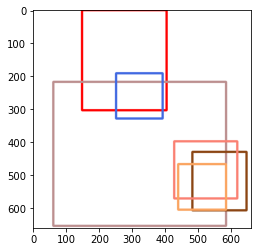

gt


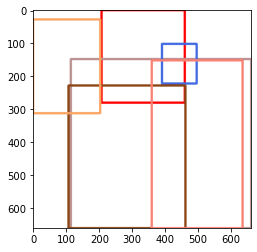

pred


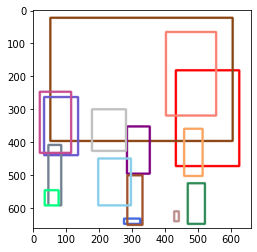

gt


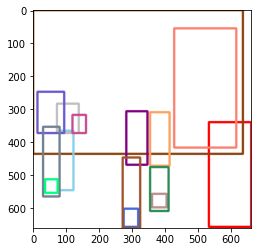

pred


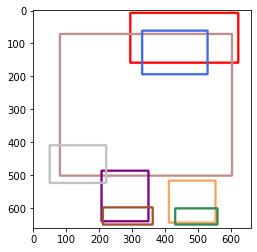

gt


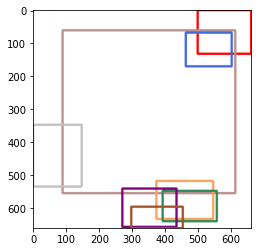

pred


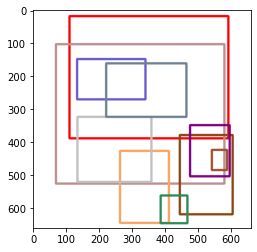

gt


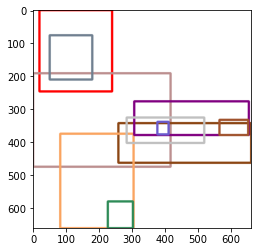

pred


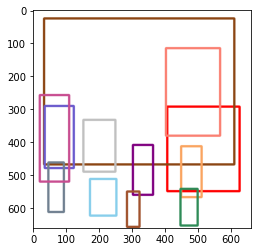

gt


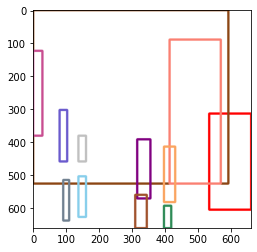

pred


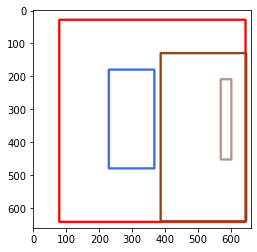

gt


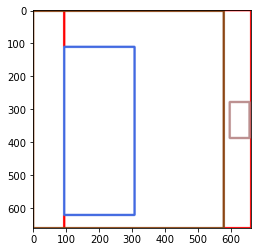

pred


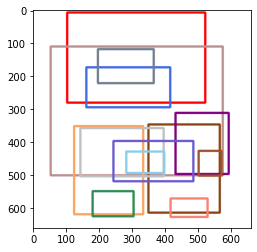

gt


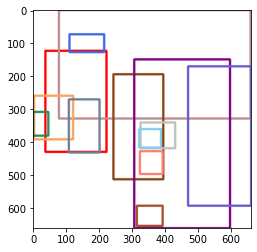

pred


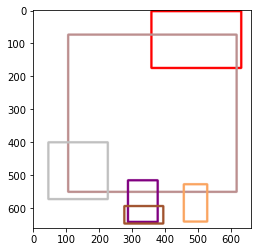

gt


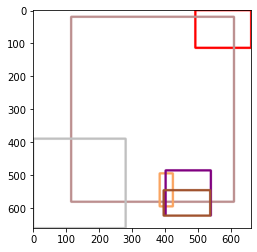

pred


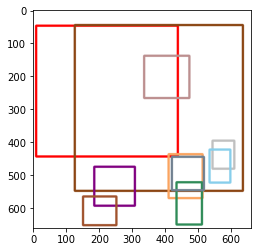

gt


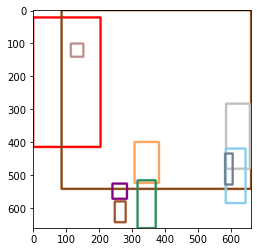

pred


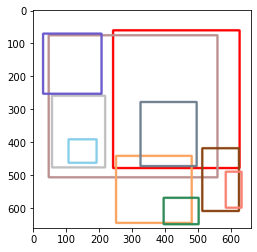

gt


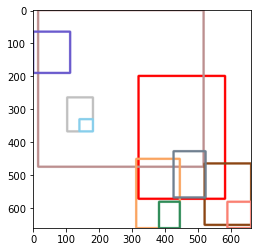

pred


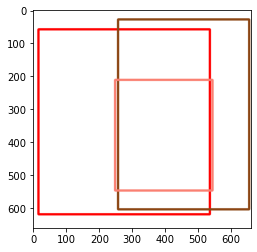

gt


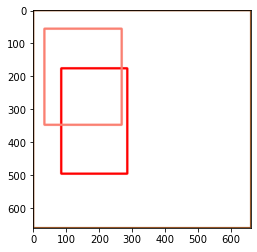

pred


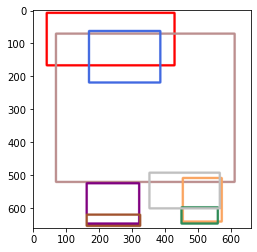

gt


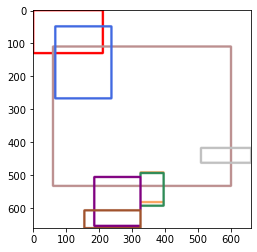

pred


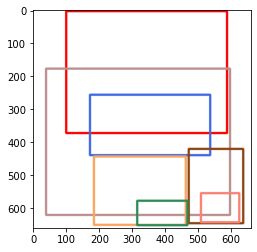

gt


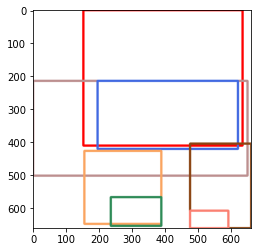

pred


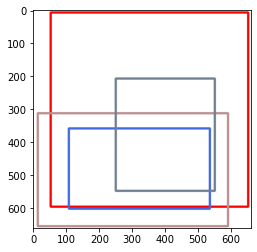

gt


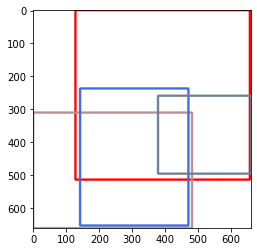

pred


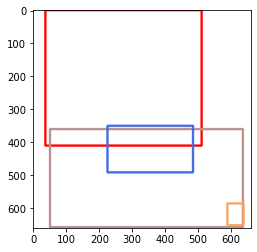

gt


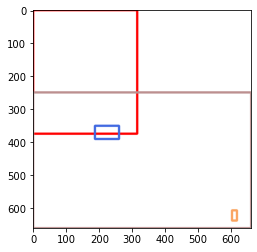

pred


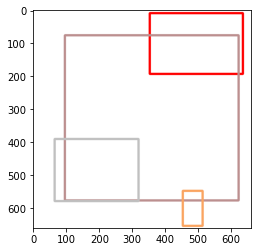

gt


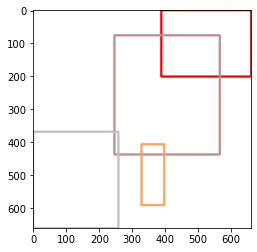

pred


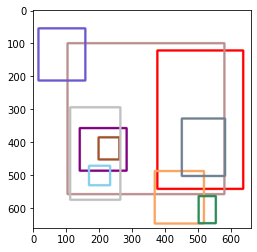

gt


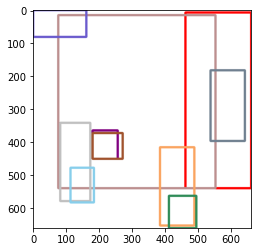

pred


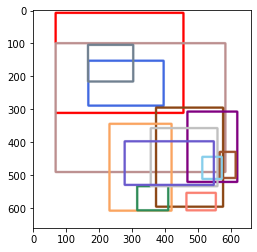

gt


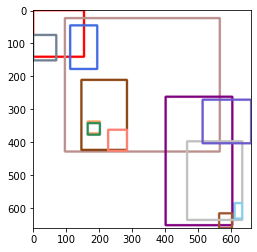

pred


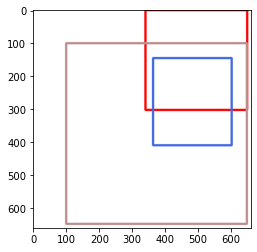

gt


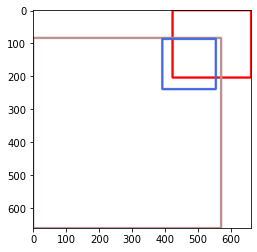

pred


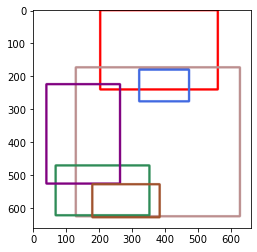

gt


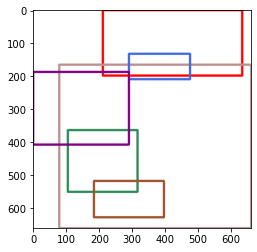

pred


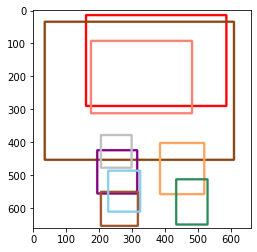

gt


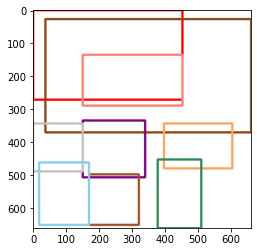

pred


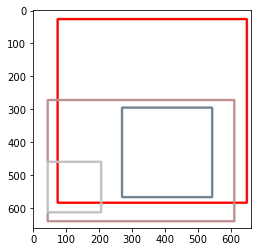

gt


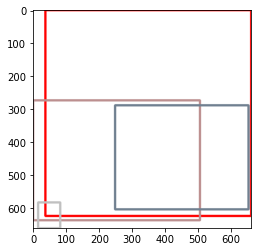

pred


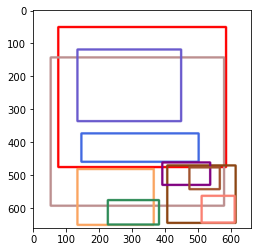

gt


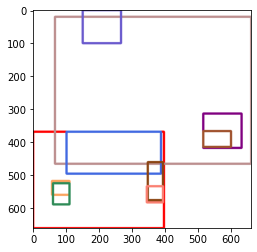

pred


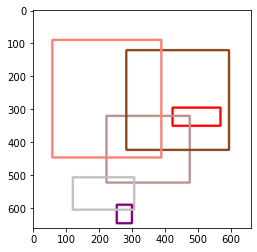

gt


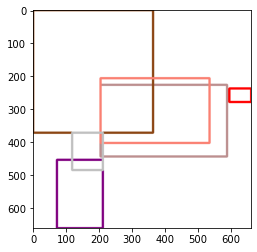

pred


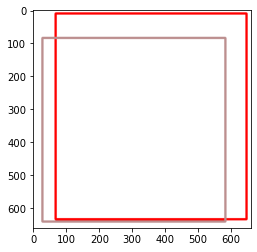

gt


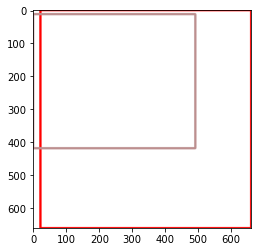

pred


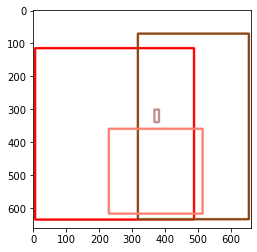

gt


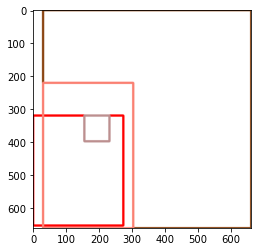

pred


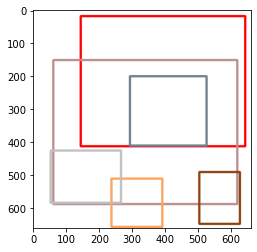

gt


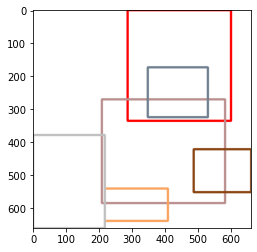

pred


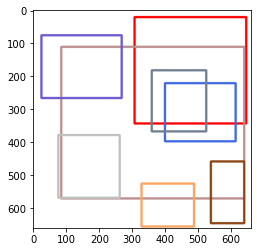

gt


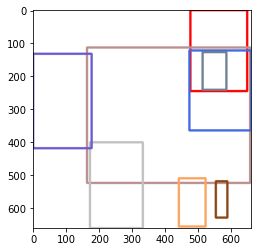

pred


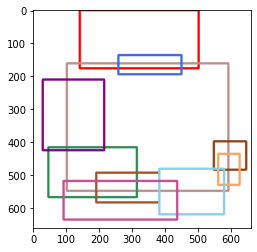

gt


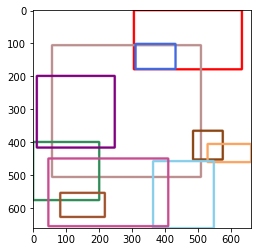

pred


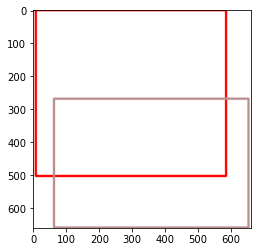

gt


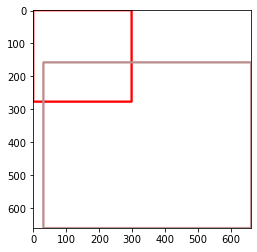

pred


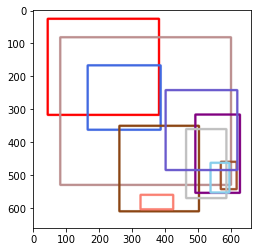

gt


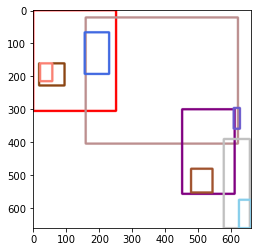

pred


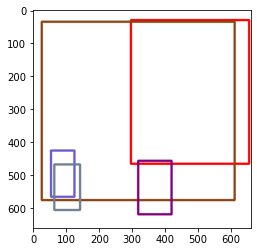

gt


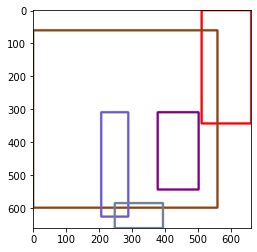

pred


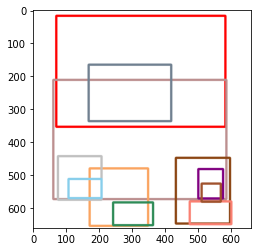

gt


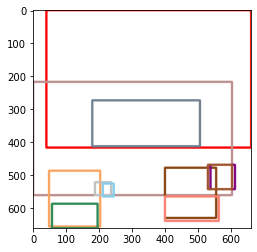

pred


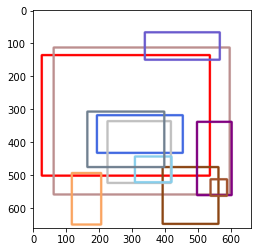

gt


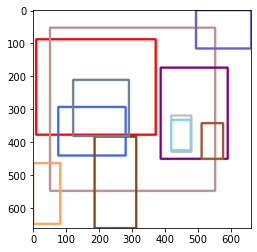

pred


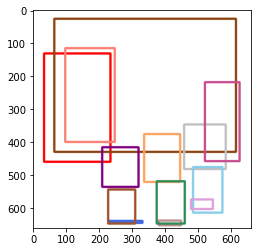

gt


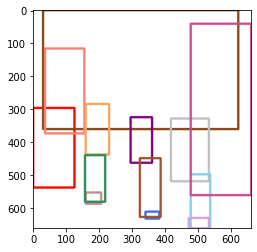

pred


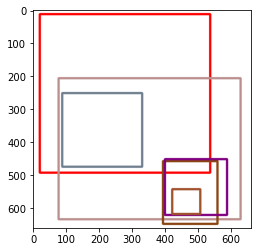

gt


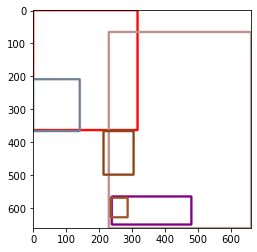

pred


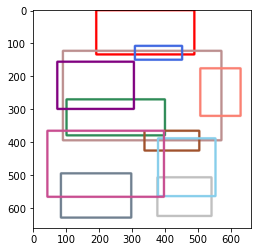

gt


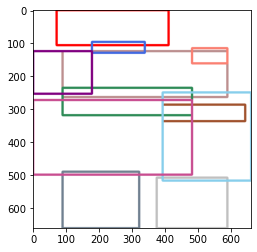

pred


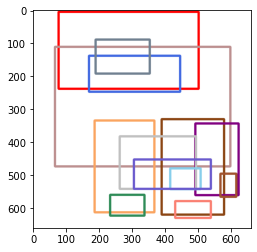

gt


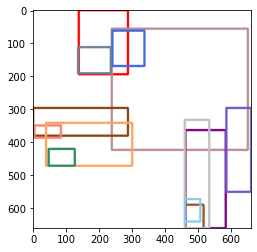

pred


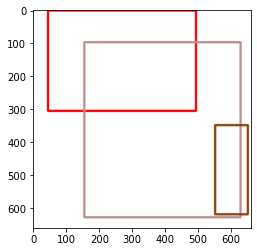

gt


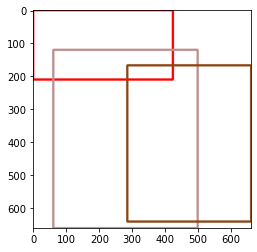

pred


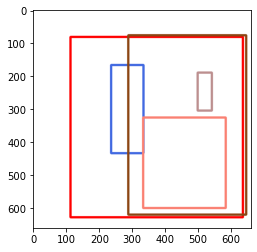

gt


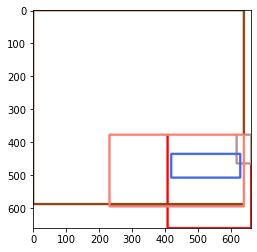

pred


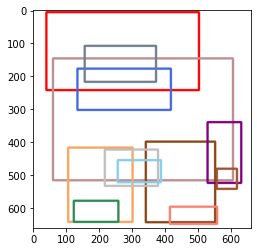

gt


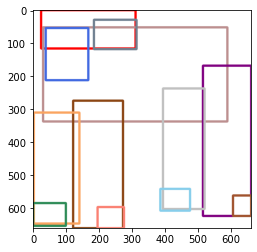

pred


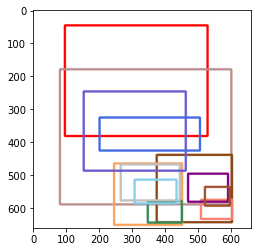

gt


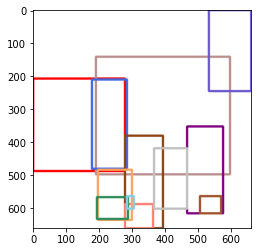

pred


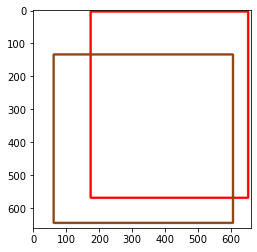

gt


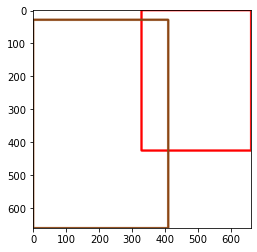

pred


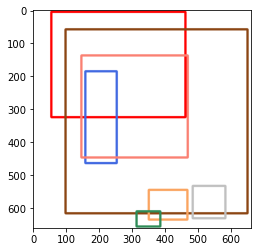

gt


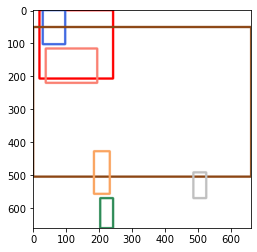

pred


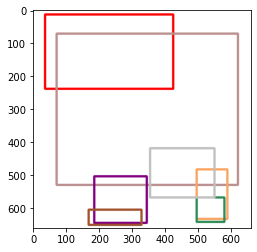

gt


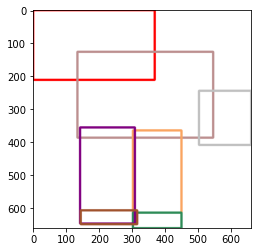

pred


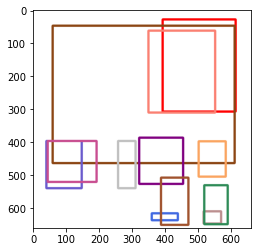

gt


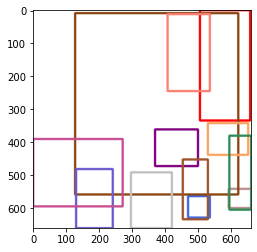

pred


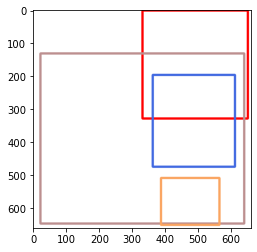

gt


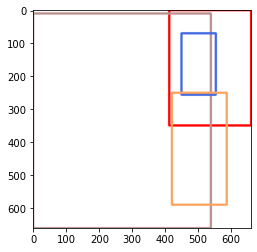

pred


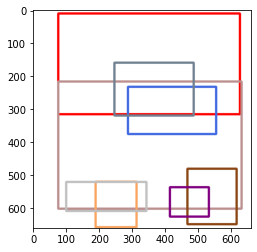

gt


KeyboardInterrupt: 

In [92]:
class_dict = ['cow', 'sheep', 'bird', 'person', 'cat', 'dog', 'horse', 'aeroplane',
              'motorbike', 'bicycle', 'car']

from collections import defaultdict
iou_loss_dict_1=defaultdict(str)
mse_loss_dict_1=defaultdict(str)
labels_dict=defaultdict(str)
coords_dict=defaultdict(str)

for i, val_data in enumerate(batch_train_loader, 0):
    
    val_data.cuda()
    node_data_true = val_data.x
    label_true = node_data_true[:,:1]
    y_true = val_data.y
    class_true = y_true[:, :num_classes]
    X_obj_true = y_true[:, num_classes:]
    adj_true = val_data.edge_index
    class_true  = torch.flatten(class_true)

    #First Model

    output_1 = vae(adj_true, node_data_true, X_obj_true, label_true , class_true)
    node_data_pred_test_1 = output_1[0]
    X_obj_pred_test_1 = output_1[1]

    # node_data_pred, X_obj_pred, label_pred, z_mean, z_logvar, margin = output
    iou_loss_1 = iou(node_data_true[:, 1:],
                     node_data_pred_test_1,
                     X_obj_true,
                     X_obj_pred_test_1,
                     label_true,
                     flag_scale = False,
                     flag_train = False).detach().to("cpu").numpy()
    # iou_loss_1 = iou(node_data_true[:,1:], node_data_pred_test_1 , X_obj_true, X_obj_pred_test_1, label_true)
    img = plot_bbx(node_data_pred_test_1[0]*label_true[:16])
    gt_img = plot_bbx(node_data_true[:16,1:])
    print('pred')
    plt.imshow(img)
    plt.show()
    print('gt')
    plt.imshow(gt_img)
    plt.show()
    mse_loss_1=loss.mse_loss(node_data_pred_test_1, node_data_true[:,1:])
#     iou_loss_1 = iou_loss_1.to('cpu')
#     iou_loss_1 = iou_loss_1.detach().numpy() 
#     mse_loss_1 = mse_loss_1.to('cpu')
#     mse_loss_1 = mse_loss_1.detach().numpy()

   
    
    label_true_reshaped = label_true.reshape((iou_loss_1.shape[0],iou_loss_1.shape[1]))
    label_true_reshaped = label_true_reshaped.to('cpu')
    label_true_reshaped = label_true_reshaped.detach().numpy()
    
    
    
    node_data_true_reshaped = node_data_true.reshape((iou_loss_1.shape[0],iou_loss_1.shape[1] , node_data_true.shape[1]))
    node_data_true_reshaped = node_data_true_reshaped.to('cpu')
    node_data_true_reshaped = node_data_true_reshaped.detach().numpy()

    
    for j in range(iou_loss_1.shape[0]):
        class_i = class_dict[int(np.argmax(class_true[num_classes*j:num_classes*(j+1)].detach().to('cpu').numpy()).tolist())]
        if class_i in iou_loss_dict_1:
            labels_dict[class_i].append(label_true_reshaped[j])
            coords_dict[class_i].append(node_data_true_reshaped[j])
            iou_loss_dict_1[class_i].append(iou_loss_1[j])
            mse_loss_dict_1[class_i].append(mse_loss_1[j].detach().to("cpu").numpy())
        else:
            print(class_i)
            labels_dict[class_i]=  [label_true_reshaped[j]]
            coords_dict[class_i] = [node_data_true_reshaped[j]]
            iou_loss_dict_1[class_i]=[iou_loss_1[j]]
            mse_loss_dict_1[class_i]=[mse_loss_1[j].detach().to("cpu").numpy()]
            print(class_i + " done in Dict-1" )
           
            print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")

    


In [88]:
label_true.shape

torch.Size([2048, 1])

In [59]:
selected_class = ['cow', 'sheep', 'bird', 'person', 'cat', 'dog', 'horse']

In [60]:
# The IOU_LOSS dictionary has the values for all the parts. This function computes the average IOU and MSE Value per part for each class.

def dict_summation(loss_dict,counts_dict_final):
    loss_dict_final={}
    parts=[i for i in range(num_nodes)]
    for class_i in loss_dict:
        temp_list=np.squeeze(np.nan_to_num(np.array(loss_dict[class_i])).sum(axis=0))/np.squeeze(counts_dict_final[class_i])
        loss_dict_final[class_i]=temp_list
    return loss_dict_final


    

In [61]:
parts=[i for i in range(num_nodes)]

# counts_dict_final is the number of each part for each class in the entire dataset
counts_dict_final={}
for class_i in labels_dict:
    temp_list=np.array(labels_dict[class_i]).sum(axis=0)
    counts_dict_final[class_i]=temp_list
    
# Computing the final dictionaries used for displaying results
iou_loss_dict_final_1=dict_summation(iou_loss_dict_1,counts_dict_final)

# Computing the final dictionaries used for displaying results
mse_loss_dict_final_1=dict_summation(mse_loss_dict_1,counts_dict_final)

# Rounding off the IOU values and scaling the MSE values approprately
for class_i in iou_loss_dict_final_1:
    iou_loss_dict_final_1[class_i] = np.round(iou_loss_dict_final_1[class_i],3)
        
    mse_loss_dict_final_1[class_i] = mse_loss_dict_final_1[class_i]*(660*660)
    mse_loss_dict_final_1[class_i] = np.round(mse_loss_dict_final_1[class_i],1)

        

C:\Users\user\AppData\Local\Temp/ipykernel_592/840667198.py:7: RuntimeWarning: invalid value encountered in true_divide
  temp_list=np.squeeze(np.nan_to_num(np.array(loss_dict[class_i])).sum(axis=0))/np.squeeze(counts_dict_final[class_i])
C:\Users\user\AppData\Local\Temp/ipykernel_592/840667198.py:7: RuntimeWarning: divide by zero encountered in true_divide
  temp_list=np.squeeze(np.nan_to_num(np.array(loss_dict[class_i])).sum(axis=0))/np.squeeze(counts_dict_final[class_i])


In [62]:
# This function computes the statistics for all the parts for each object. For eg, mean area, median area etc.
import pandas as pd
stats_dict_final={}
for class_i in coords_dict:
    final_list=[[] for i in range(num_nodes)]
    for part_num in parts:
        temp_list=[[] for i in range(num_nodes)]
        for ele in coords_dict[class_i]:
            temp_tuple=ele[part_num]
            if int(temp_tuple[0]) != 0:
                temp_list[part_num].append(abs(temp_tuple[3]-temp_tuple[1]) * abs(temp_tuple[4]-temp_tuple[2]))
        s=pd.Series(temp_list[part_num], dtype='float64')
        final_list[part_num].append(s.mean())
        final_list[part_num].append(s.quantile(q=0.25))
        final_list[part_num].append(s.quantile(q=0.50))
        final_list[part_num].append(s.quantile(q=0.75))
    stats_dict_final[class_i] = final_list
    
# Computes the average ratio of the sides for each part
side_ratios_dict_final={}
for class_i in coords_dict:
    final_list=[0 for i in range(num_nodes)]
    for part_num in parts:
        temp_list=[[] for i in range(num_nodes)]
        for ele in coords_dict[class_i]:
            temp_tuple=ele[part_num]
            if int(temp_tuple[0]) != 0:
                temp_ratio=(abs(temp_tuple[3]-temp_tuple[1])*10000)/(abs(temp_tuple[4]-temp_tuple[2])*10000)
                if temp_ratio < 1:
                    temp_ratio = 1/temp_ratio 
                temp_list[part_num].append(temp_ratio)
        s=pd.Series(temp_list[part_num], dtype='float64')
        final_list[part_num]=s.mean()
    side_ratios_dict_final[class_i] = final_list
    


for class_i in side_ratios_dict_final:
    for part in range(num_nodes):
        side_ratios_dict_final[class_i][part] = round(side_ratios_dict_final[class_i][part],3)
        for i in range(4):
            stats_dict_final[class_i][part][i] = round(stats_dict_final[class_i][part][i],3)
        
# This function can be used to print the IOU / MSE values for all the classes for each model.
# Can change the model by changing the dictionary used as a parameter in the class_iou function.
# I am simply printing the values in this fashion and copying them into the excel sheet since could not find function to create tables like Excel tables
# for current_class in selected_class:
#     print(round(class_iou(mse_loss_dict_final_1,counts_dict_final,current_class),3))

C:\Users\user\AppData\Local\Temp/ipykernel_592/1194310171.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  temp_ratio = 1/temp_ratio
C:\Users\user\AppData\Local\Temp/ipykernel_592/1194310171.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  temp_ratio=(abs(temp_tuple[3]-temp_tuple[1])*10000)/(abs(temp_tuple[4]-temp_tuple[2])*10000)
C:\Users\user\AppData\Local\Temp/ipykernel_592/1194310171.py:28: RuntimeWarning: invalid value encountered in double_scalars
  temp_ratio=(abs(temp_tuple[3]-temp_tuple[1])*10000)/(abs(temp_tuple[4]-temp_tuple[2])*10000)


In [63]:
def class_iou(loss_dict_final,counts_dict_final,current_class):
    total_count=0
    total_val=0
    for part in range(num_nodes):
        loss_dict_final[current_class] = np.nan_to_num(loss_dict_final[current_class])
        total_val+=loss_dict_final[current_class][part] * counts_dict_final[current_class][part]
        total_count+=counts_dict_final[current_class][part]
    total_val=total_val/total_count
    return total_val

In [93]:
for current_class in selected_class:
    print(current_class, round(class_iou(iou_loss_dict_final_1,counts_dict_final,current_class),3))

cow 0.24
sheep 0.279
bird 0.25
person 0.313
cat 0.272
dog 0.257
horse 0.21


In [30]:
for current_class in selected_class:
    print(round(class_iou(iou_loss_dict_final_1,counts_dict_final,current_class),3))

0.603
0.685
0.657
0.638
0.66
0.64
0.563


In [31]:
# cat_labels = {'head':1, 'leye':2, 'reye':3, 'lear':4, 'rear':5, 'nose':6, 'torso':7, 'neck':8, 'lfleg':9, 'lfpa':10, 'rfleg':11, 'rfpa':12, 'lbleg':13, 'lbpa':14, 'rbleg':15, 'rbpa':16, 'tail':17}


# cow_labels = {'head':1, 'leye':2, 'reye':3, 'lear':4, 'rear':5, 'muzzle':6, 'lhorn':7, 'rhorn':8, 'torso':9, 'neck':10, 'lfuleg':11, 'lflleg':12, 'rfuleg':13, 'rflleg':14, 'lbuleg':15, 'lblleg':16, 'rbuleg':17, 'rblleg':18, 'tail':19}



# dog_labels = {'head':1, 'leye':2, 'reye':3, 'lear':4, 'rear':5, 'nose':6, 'torso':7, 'neck':8, 'lfleg':9, 'lfpa':10, 'rfleg':11, 'rfpa':12, 'lbleg':13, 'lbpa':14, 'rbleg':15, 'rbpa':16, 'tail':17, 'muzzle':18}


# horse_labels = {'head':1, 'leye':2, 'reye':3, 'lear':4, 'rear':5, 'muzzle':6, 'lfho':7, 'rfho':8, 'torso':9, 'neck':10, 'lfuleg':11, 'lflleg':12, 'rfuleg':13, 'rflleg':14, 'lbuleg':15, 'lblleg':16, 'rbuleg':17, 'rblleg':18, 'tail':19, 'lbho':20, 'rbho':21}


# person_labels = {'head':1, 'leye':2, 'reye':3, 'lear':4, 'rear':5, 'lebrow':6, 'rebrow':7, 'nose':8, 'mouth':9, 'hair':10, 'torso':11, 'neck': 12, 'llarm': 13, 'luarm': 14, 'lhand': 15, 'rlarm':16, 'ruarm':17, 'rhand': 18, 'llleg': 19, 'luleg':20, 'lfoot':21, 'rlleg':22, 'ruleg':23, 'rfoot':24}

# sheep_labels = cow_labels



# part_labels = {'bird': bird_labels, 'cat': cat_labels, 'cow': cow_labels, 'dog': dog_labels, 'sheep': sheep_labels, 'horse':horse_labels, 'bicycle':bicycle_labels, 'motorbike':motorbike_labels, 'person':person_labels,'aeroplane':aeroplane_labels}

bird_labels = {'head':1 , 'torso':2, 'neck':3, 'lwing':4, 'rwing':5, 'lleg':6, 'lfoot':7, 'rleg':8, 'rfoot':9, 'tail':10}
cat_labels = {'head':1, 'torso':2, 'neck':3, 'lfleg':4, 'lfpa':5, 'rfleg':6, 'rfpa':7, 'lbleg':8, 'lbpa':9, 'rbleg':10, 'rbpa':11, 'tail':12}
cow_labels = {'head':1,'lhorn':2, 'rhorn':3, 'torso':4, 'neck':5, 'lfuleg':6, 'lflleg':7, 'rfuleg':8, 'rflleg':9, 'lbuleg':10, 'lblleg':11, 'rbuleg':12, 'rblleg':13, 'tail':14}
dog_labels = {'head':1,'torso':2, 'neck':3, 'lfleg':4, 'lfpa':5, 'rfleg':6, 'rfpa':7, 'lbleg':8, 'lbpa':9, 'rbleg':10, 'rbpa':11, 'tail':12, 'muzzle':13}
horse_labels = {'head':1,'lfho':2, 'rfho':3, 'torso':4, 'neck':5, 'lfuleg':6, 'lflleg':7, 'rfuleg':8, 'rflleg':9, 'lbuleg':10, 'lblleg':11, 'rbuleg':12, 'rblleg':13, 'tail':14, 'lbho':15, 'rbho':16}
person_labels = {'head':1, 'torso':2, 'neck': 3, 'llarm': 4, 'luarm': 5, 'lhand': 6, 'rlarm':7, 'ruarm':8, 'rhand': 9, 'llleg': 10, 'luleg':11, 'lfoot':12, 'rlleg':13, 'ruleg':14, 'rfoot':15}
sheep_labels = cow_labels
part_labels_combined_parts = {'bird': bird_labels, 'cat': cat_labels, 'cow': cow_labels, 'dog': dog_labels, 'sheep': sheep_labels, 'horse':horse_labels,'person':person_labels}


In [32]:

# Select the current_class
res_list = []
for current_class in selected_class:

    mean_list_final = []
    median_list_final = []
    for i in stats_dict_final[current_class]:
        mean_list_final.append(i[0])
        median_list_final.append(i[2])

    part_list=list(part_labels_combined_parts[current_class].keys())

    while len(part_list) != num_nodes:
        part_list.append("NA")

    counts_list=list(counts_dict_final[current_class])
    ratios_list=list(side_ratios_dict_final[current_class])
    mse_list_1=list(mse_loss_dict_final_1[current_class])
    iou_list_1=list(iou_loss_dict_final_1[current_class])

    data={
        "Class": [current_class]*len(part_list),
        "Part": part_list,
        "Count" : list(counts_list),
        "Mean_Area": mean_list_final,
        "Median_Area": median_list_final,
        "Avg_side_ratio": ratios_list,
        "mse": list(mse_list_1),
        "IOU": list(iou_list_1)
    }

    res_list.append(pd.DataFrame(data))


In [33]:
pd.concat(res_list).to_csv(model_path+'/part_wise_results.csv')